<a href="https://colab.research.google.com/github/hisics/-datawhisperers_final-project_dsml2021/blob/heba/Cluster_Apparel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Products based on common words

### Importing libraries and cleaned dataset

In [1]:
# Clustering
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
!pip install webcolors
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
#Load data set
df = pd.read_csv('./cleaned_apparel_dataset.csv')
text1 = df['product_title']
#Remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]

#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

text3 = pd.Series([stemSentence(x) for x in text2])

#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text3)

# #TF-IDF (word level)
vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(text3)

#TF-IDF (n-gram level)
vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,4))
X_ntf = vectorizer_ntf.fit_transform(text3)

### Simple EDA on product title & elbow method for clustering

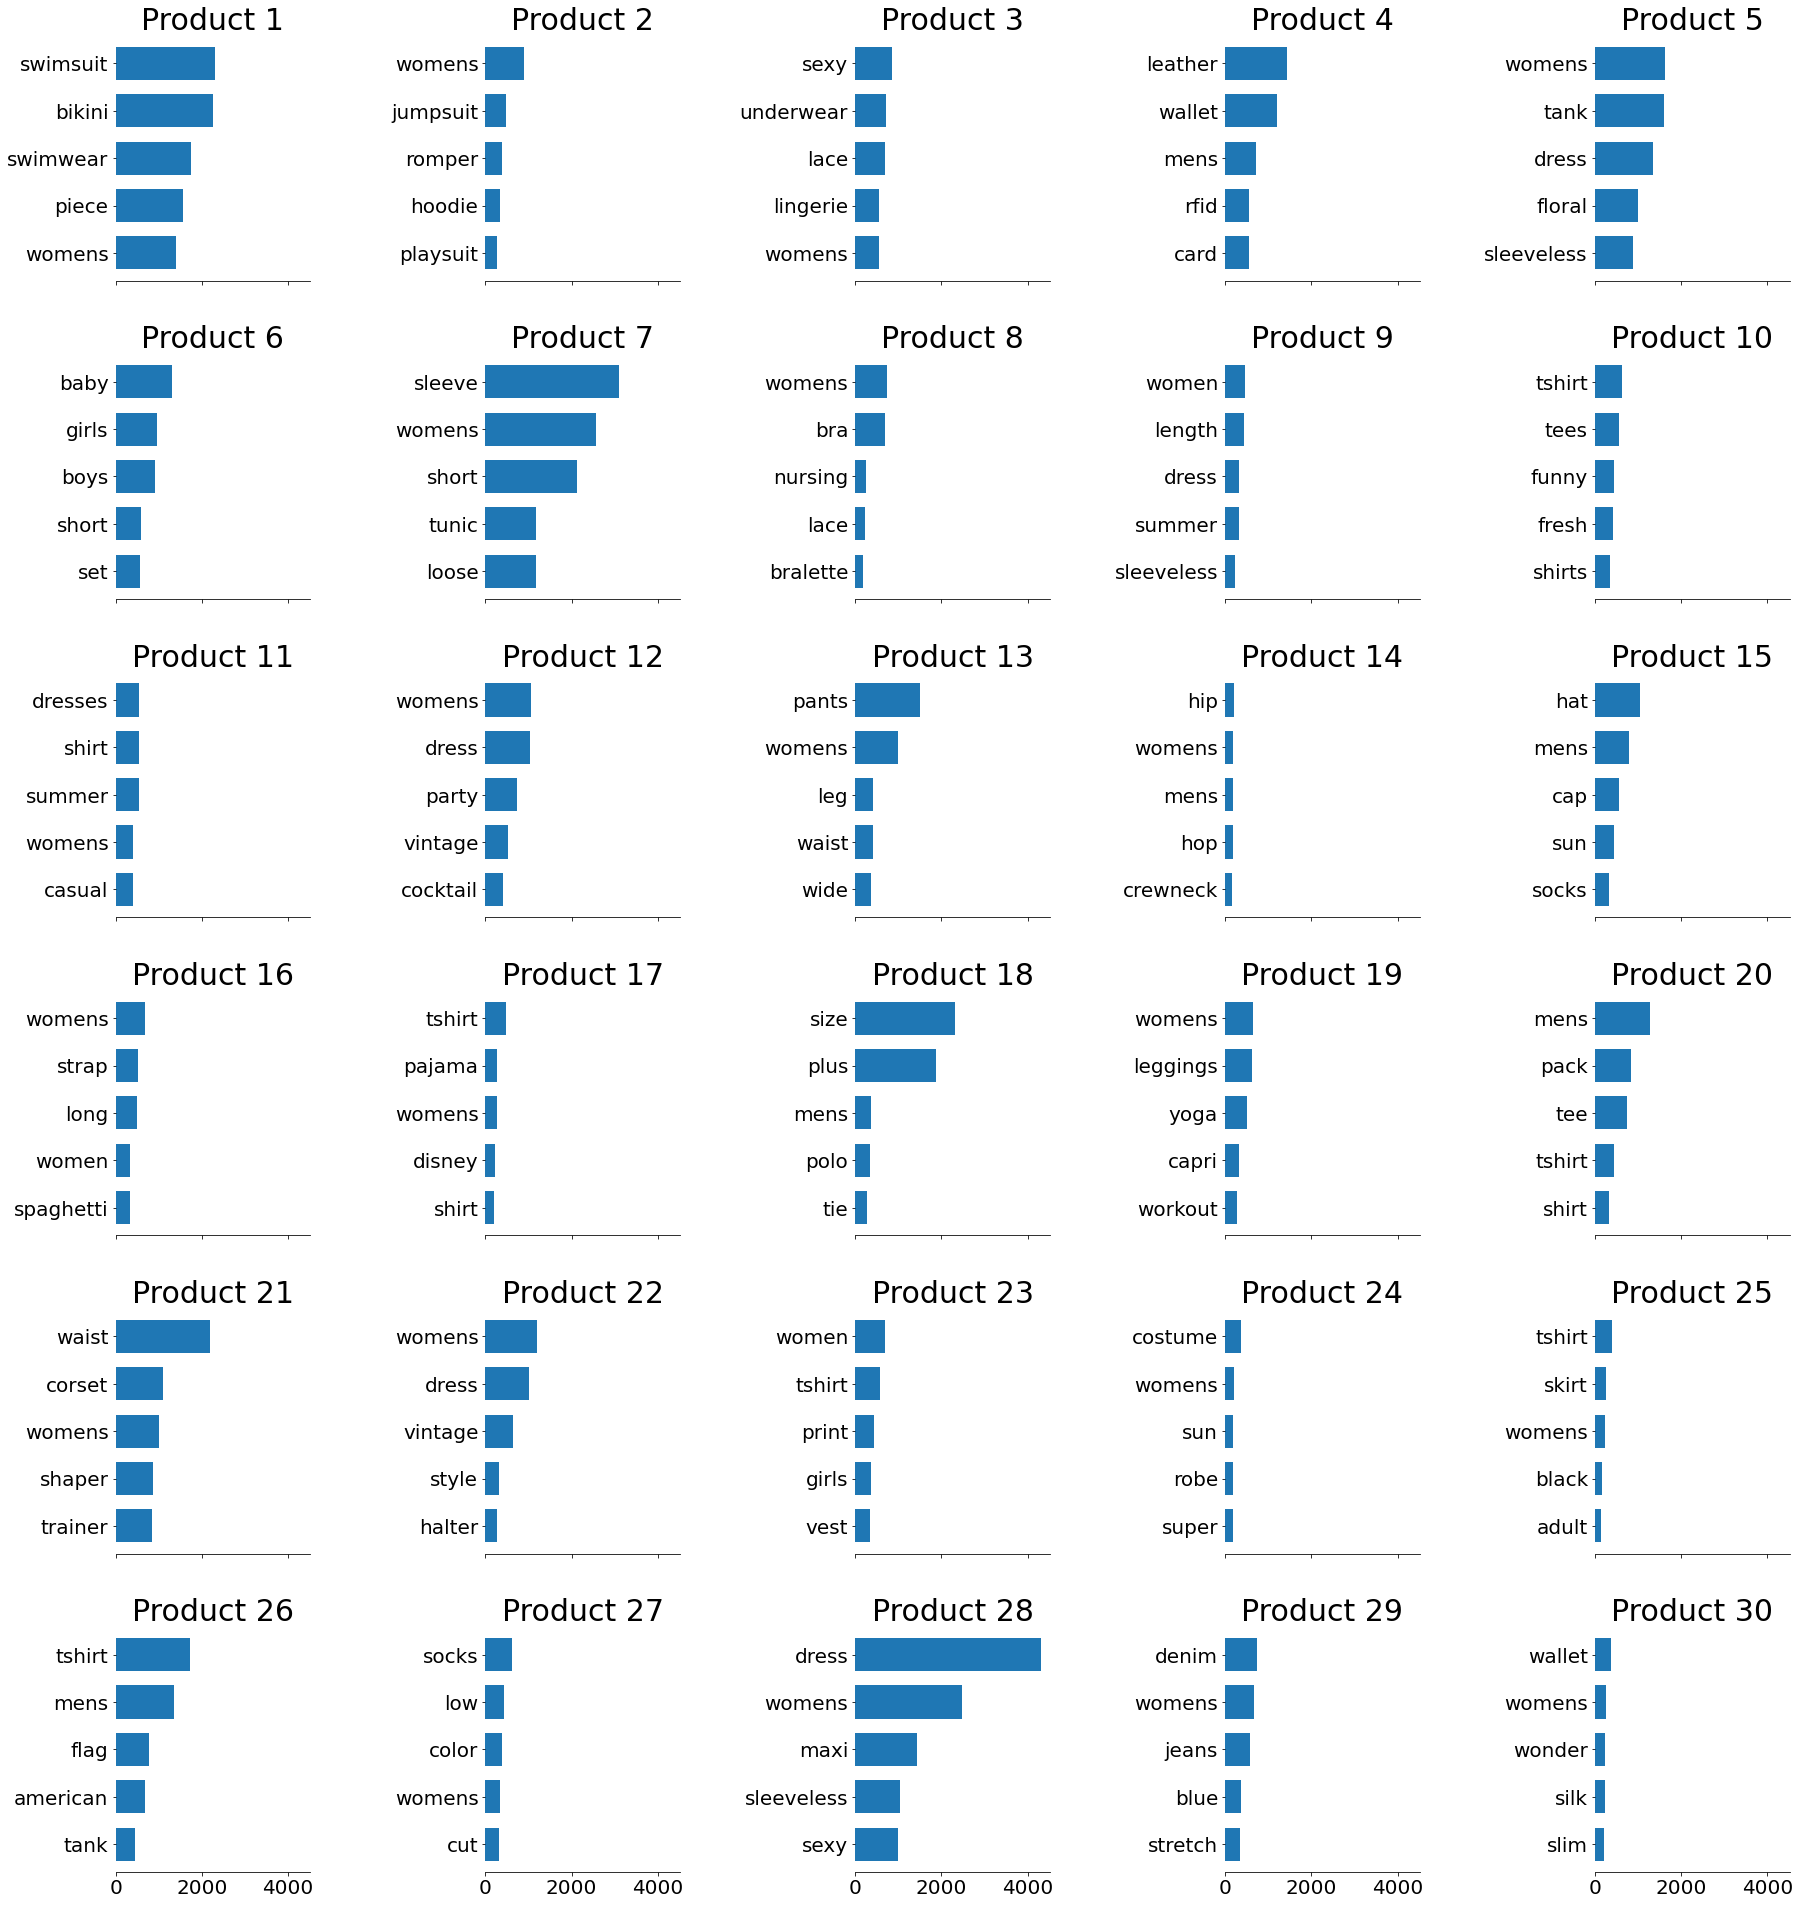

In [8]:
#LDA
lda = LatentDirichletAllocation(n_components=30, learning_decay=0.9)
X_lda = lda.fit(X_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Product {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics
n_top_words = 5
feature_names = vectorizer_cv.get_feature_names_out()
plot_top_words(X_lda, feature_names, n_top_words, '')

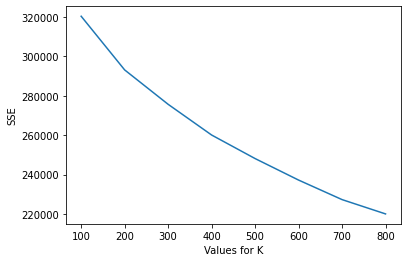

In [ ]:
#Test increments of 100 clusters using elbow method
#SSE: sum of squared error
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show()

### Clustering Products

In [3]:
# clustering products 
kmeans = KMeans(n_clusters=200)
kmeans.fit(X_cv)
result = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names_out())],axis=1)
result['cluster'] = kmeans.predict(X_cv)
result[['product_title','cluster']]


,product_title,cluster
0,easy tool stainless steel fruit pineapple core...,45
1,v women cowl neck knit stretchable elasticity ...,162
2,james fiallo mens pairs low cut athletic sport...,2
3,belfry gangster wool stainresistant crushable...,151
4,jaeden womens beaded spaghetti straps sexy lon...,49
...,...,...
49969,pk mens authentic crisp printed boxer briefs c...,97
49970,pk mens authentic crisp printed boxer briefs c...,97
49971,pk mens authentic crisp printed boxer briefs c...,97
49972,pk mens authentic crisp printed boxer briefs c...,97


In [5]:
# X_cv.pd_to_csv('./vectorized-title.csv')
result.to_csv('./product-title_cluster.csv')

In [11]:
# result[['product_title','cluster']].to_csv('./productCluster-title_cluster.csv')

# from google.colab import files
# files.download("productCluster-title_cluster.csv")
files.download('product-title_cluster.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Label each cluster with the word(s) that all of its products names have in common
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='product_title' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','labels'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')


In [6]:
pd.pivot_table(result_labelled,index=['label'],values = ['product_title'], aggfnuc = 'count').sort_values(['product_title'],ascending = False)

NameError: ignored

In [52]:
# !pip install --upgrade plotly
# #Visualise sizes of categories (manually added to result_labelled) and clean clusters
# result_summary = pd.pivot_table(result_labelled,index=['label'],values=['product_title'],aggfunc= 'count').reset_index().rename(columns={'product_title':'count'})
# result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
# fig = px.treemap(result_treemap,values='count')
# # result_treemap
# # result_summary
# fig.show()


#Visualise sizes of categories (manually added to result_labelled) and clean clusters
result_summary = pd.pivot_table(result_labelled,index=['label','category'],values=['Name'],aggfunc='count').reset_index().rename(columns={'Name':'count'})
result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
fig = px.treemap(result_treemap,path=['category','label'],values='count')
fig.show();